# Piece Reconition

Klassifiziert Schachfiguren

In [35]:
import torch
import torchvision
import torchvision.transforms as transforms

img_size = (128, 128)

transform_valid = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 32  # auf uni server höhere batch size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"  GPU: {torch.cuda.get_device_name(0)}")

from utils import BoardCropsDataset, CLASS_NAMES

BOARD_ROOT = "./pieces_on_board"
trainset = BoardCropsDataset(BOARD_ROOT, split="train", transform=transform_train)
validset = BoardCropsDataset(BOARD_ROOT, split="valid", transform=transform_valid)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=(device.type == 'cuda'))
validloader = torch.utils.data.DataLoader(
    validset, batch_size=batch_size, shuffle=False,
    num_workers=4, pin_memory=(device.type == 'cuda'))

classes = CLASS_NAMES
print("Klassen:", classes)
print("Train-Samples (Crops):", len(trainset), "Valid:", len(validset))

Device: cpu
Klassen: ['black-camel', 'black-elephant', 'black-horse', 'black-king', 'black-pawn', 'black-queen', 'white-camel', 'white-elephant', 'white-horse', 'white-king', 'white-pawn', 'white-queen']
Train-Samples (Crops): 1269 Valid: 118


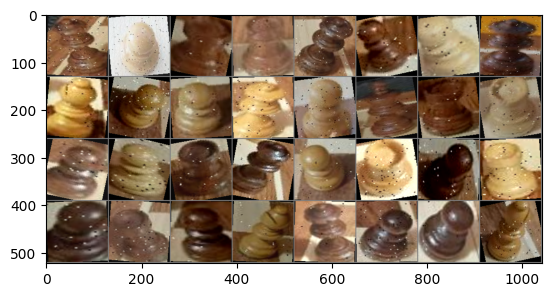

Labels: black-queen white-pawn black-elephant black-elephant black-queen black-pawn white-pawn black-queen white-camel white-pawn white-pawn white-queen white-pawn black-king black-elephant white-elephant black-pawn white-pawn black-elephant black-queen white-pawn white-elephant black-pawn white-elephant black-pawn black-elephant black-pawn white-camel black-queen black-pawn black-pawn white-camel


In [36]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('Labels:', ' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

### Neuronales Netz

In [37]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.adapt = nn.AdaptiveAvgPool2d(5)
        self.fc1 = nn.Linear(64 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 12)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.adapt(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

### Optimizer und Loss-Function

In [38]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

### Training

In [39]:
num_epochs = 50
best_val_acc = 0.0
net.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i + 1) % 50 == 0:
            print(f'  epoch {epoch+1} batch {i+1}/{len(trainloader)} loss: {running_loss / (i+1):.3f}')
    train_loss = running_loss / len(trainloader)
    net.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for data in validloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    val_loss /= len(validloader)
    scheduler.step(val_loss)
    net.train()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(net.state_dict(), './piece-rec-best.pth')
    print(f'[Epoch {epoch+1}/{num_epochs}] train loss: {train_loss:.3f} | val loss: {val_loss:.3f} | val acc: {val_acc:.1f}% (best: {best_val_acc:.1f}%)')
print('Finished Training')

[Epoch 1/50] train loss: 2.131 | val loss: 1.580 | val acc: 44.9% (best: 44.9%)
[Epoch 2/50] train loss: 1.774 | val loss: 1.560 | val acc: 45.8% (best: 45.8%)
[Epoch 3/50] train loss: 1.665 | val loss: 1.435 | val acc: 44.9% (best: 45.8%)
[Epoch 4/50] train loss: 1.636 | val loss: 1.480 | val acc: 44.9% (best: 45.8%)
[Epoch 5/50] train loss: 1.544 | val loss: 1.519 | val acc: 44.9% (best: 45.8%)
[Epoch 6/50] train loss: 1.481 | val loss: 1.662 | val acc: 48.3% (best: 48.3%)
[Epoch 7/50] train loss: 1.434 | val loss: 1.387 | val acc: 48.3% (best: 48.3%)
[Epoch 8/50] train loss: 1.347 | val loss: 1.229 | val acc: 55.1% (best: 55.1%)
[Epoch 9/50] train loss: 1.230 | val loss: 1.206 | val acc: 55.1% (best: 55.1%)


KeyboardInterrupt: 

### Model speichern

In [ ]:
PATH = './piece-rec.pth'
torch.save(net.state_dict(), PATH)

### Testen

In [ ]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in validloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on validation set: {100 * correct / total:.1f}%')

Accuracy on validation set: 20.0%


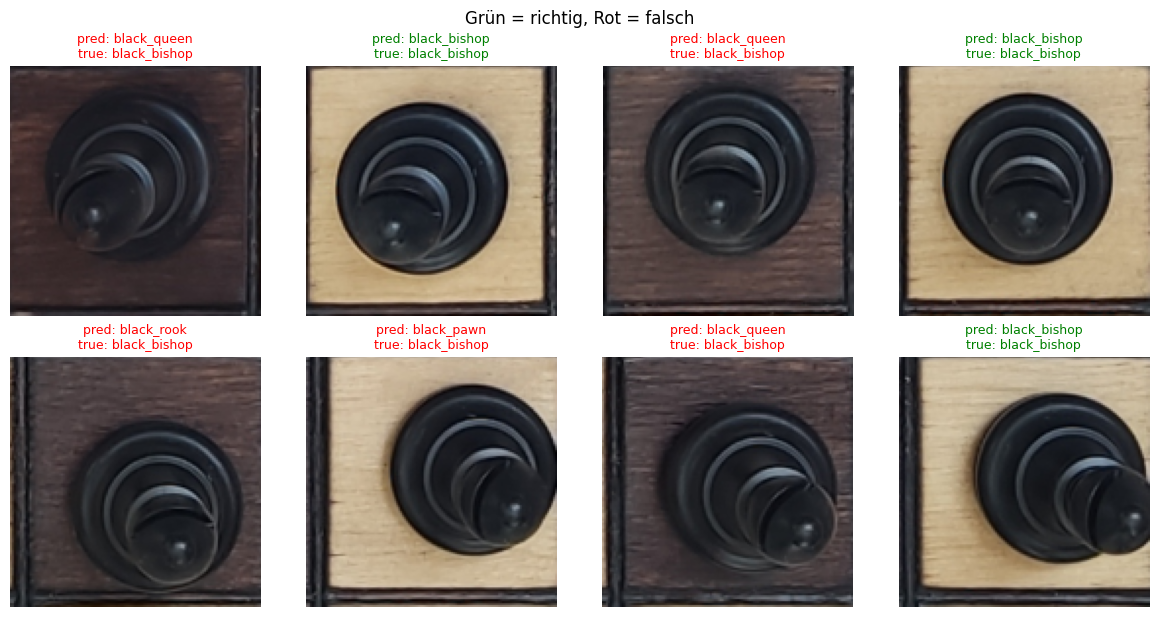

In [ ]:
import matplotlib.pyplot as plt

net.eval()
dataiter = iter(validloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

n_show = min(8, images.size(0))
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()
for i in range(n_show):
    img = images[i].cpu() / 2 + 0.5
    img = img.numpy().transpose(1, 2, 0)
    axes[i].imshow(img)
    pred_str = classes[predicted[i].item()]
    true_str = classes[labels[i].item()]
    ok = predicted[i] == labels[i]
    axes[i].set_title(f'pred: {pred_str}\ntrue: {true_str}', fontsize=9, color='green' if ok else 'red')
    axes[i].axis('off')
for j in range(n_show, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.suptitle('Grün = richtig, Rot = falsch', y=1.02)
plt.show()